In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from IPython.display import display
from sklearn.linear_model import LogisticRegression
# from collections import Counter
# from sklearn.linear_model import LogisticRegression
from statistics import *
# from sklearn import metrics
import feather
import seaborn as sns
from collections import Counter
# from sklearn.model_selection import
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score,classification_report,confusion_matrix
from imblearn.over_sampling import RandomOverSampler,SMOTE
from xgboost import XGBClassifier

Using TensorFlow backend.


In this we join all the tables and Using RFM(Recency,Frequency and Monetary ) to create features to help us Predict better

In [4]:
df = pd.read_csv("D:/Kaggle/WNS/train.csv",low_memory=False,parse_dates=['impression_time'])
df_new_log = feather.read_dataframe("tmp/wns_log")
df_new_items = feather.read_dataframe("tmp/wns_item")
df_recent_time = feather.read_dataframe("tmp/wns_time")

In [5]:
df_new_log.device_type.value_counts()

android    89154
iphone         3
Name: device_type, dtype: int64

In [26]:
df.head()


,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [27]:
df.is_click.value_counts()

0    226747
1     10862
Name: is_click, dtype: int64

In [6]:
df_raw = pd.merge(df,df_new_log,how='inner',on='user_id')
df_raw = pd.merge(df_raw,df_recent_time,how='inner',on='user_id')
df_raw = pd.merge(df_raw,df_new_items,how='inner',on='user_id')

In [7]:
df_raw.tail().T

,231805,231806,231807,231808,231809
impression_id,aab3e5cfa95a1bcdc533676ae1f89ca4,4e9d8ddbca4200088db3e721309a4583,dee7f0842c44025588c2360042eef2cf,d5933a70c5da3152b798aa66e3bde144,71b3ab4d5d64a2c7626c2db5370037e6
impression_time,2018-12-13 07:15:00,2018-12-13 07:20:00,2018-12-13 07:22:00,2018-12-13 07:27:00,2018-12-13 07:28:00
user_id,51422,19286,89765,43386,2699
app_code,3,127,207,386,207
os_version,latest,latest,latest,intermediate,intermediate
is_4G,0,1,1,0,0
is_click,0,0,0,0,0
device_type,android,android,android,android,android
server_accessed,15,67,24,141,29
unique_items_checked,12,46,21,97,18


In [8]:
train_cats(df_raw)

In [9]:
df_raw.os_version.cat.set_categories(['latest','intermediate','old'],ordered=True,inplace=True)

In [10]:
df_raw.os_version  = df_raw.os_version.cat.codes
df_raw.device_type = df_raw.device_type.cat.codes

Here we See the data is highly imbalanced too

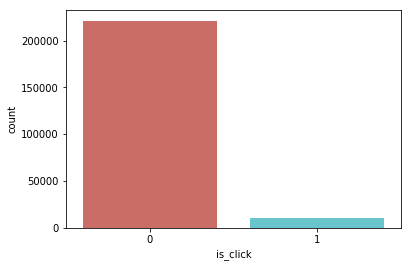

In [11]:
import matplotlib.pyplot as plt
sns.countplot(x='is_click',data=df_raw, palette='hls')
plt.show();

In [35]:
df_raw.impression_time.describe()

count                  231810
unique                  36370
top       2018-12-04 00:01:00
freq                       43
first     2018-11-15 00:00:00
last      2018-12-13 07:43:00
Name: impression_time, dtype: object

Here we see the click patters of every user like when they click the most the time the day, hour , month etc

Text(0.5, 0, 'impression_time')

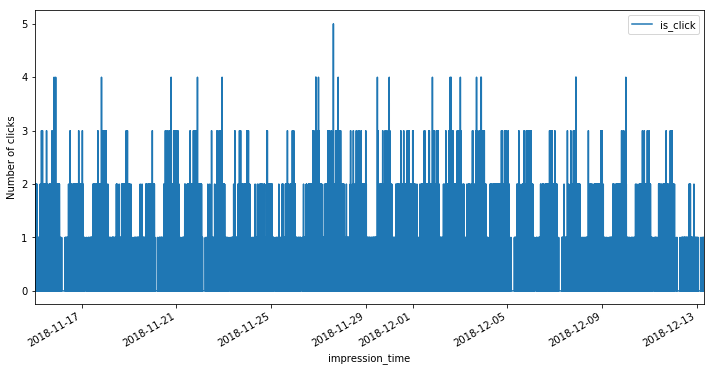

In [36]:
df_raw.groupby('impression_time').agg({'is_click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.xlabel('impression_time')

Text(0.5, 0, 'hour')

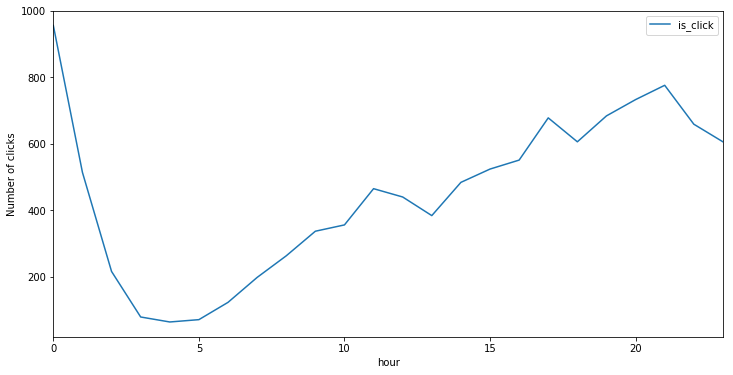

In [74]:
df_raw['hour_of_day'] = df_raw.impression_time.apply(lambda x: x.hour)
df_raw.groupby('hour_of_day').agg({'is_click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.xlabel('hour')

Text(0.5, 0, 'Hourly impressions')

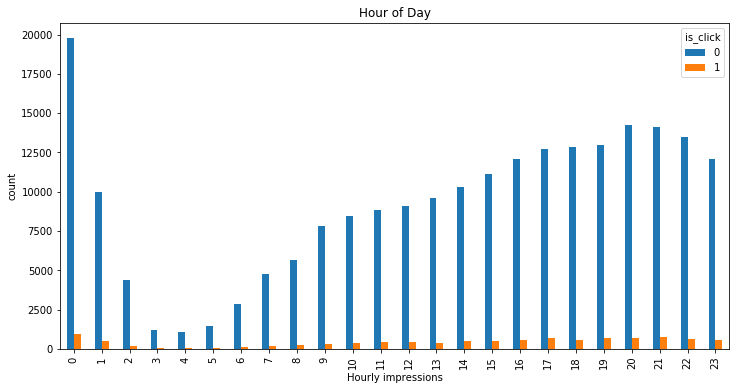

In [13]:
df_raw.groupby(['hour_of_day','is_click']).size().unstack().plot(kind= 'bar',title="Hour of Day",figsize=(12,6))
plt.ylabel('count')
plt.xlabel('Hourly impressions')

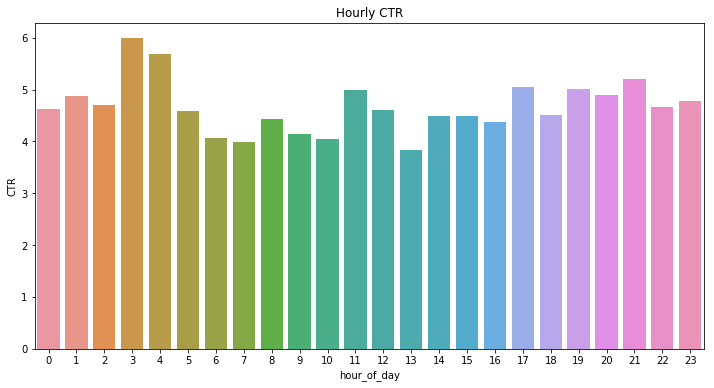

In [42]:
df_click = df_raw[df_raw['is_click'] == 1]
df_hour = df_raw[['hour_of_day','is_click']].groupby(['hour_of_day']).count().reset_index()
df_hour = df_hour.rename(columns={'is_click': 'impressions'})
df_hour['clicks'] = df_click[['hour_of_day','is_click']].groupby(['hour_of_day']).count().reset_index()['is_click']
df_hour['CTR'] = df_hour['clicks']/df_hour['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='hour_of_day', data=df_hour)
plt.title('Hourly CTR');

In [46]:
df_raw.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,device_type,server_accessed,unique_items_checked,server_accessed_last,Avg_item_price,Most_Product_type_checked,Sec_Most_Product_type_checked,Third_Most_Product_type_checked,hour_of_day,day_of_week
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,2,0,0,0,1,1,2018-10-19 18:11:00,2350,5622,NaN,NaN,0,Thursday
1,621bf66ddb7c962aa0d22ac97d69b793,2018-11-15 00:19:00,87862,422,2,0,0,0,1,1,2018-10-19 18:11:00,2350,5622,NaN,NaN,0,Thursday
2,ab394288aed46588bdc90bf4b541ec0d,2018-11-16 17:29:00,87862,422,2,0,0,0,1,1,2018-10-19 18:11:00,2350,5622,NaN,NaN,17,Friday
3,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,0,1,1,0,12,7,2018-12-10 20:03:00,4452,577,9337.0,8411.0,0,Thursday
4,6b18886bc278247582704943f5c66eb9,2018-11-16 16:31:00,63410,467,0,1,0,0,12,7,2018-12-10 20:03:00,4452,577,9337.0,8411.0,16,Friday


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  """Entry point for launching an IPython kernel.


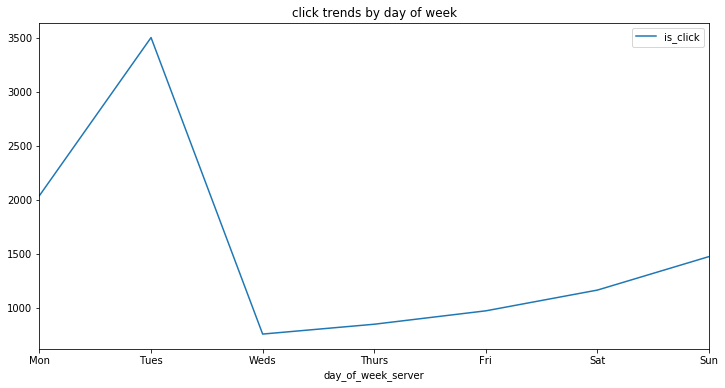

In [83]:
df_raw['day_of_week_server'] = df_raw['server_accessed_last'].apply(lambda val: val.weekday_name)
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_raw.groupby('day_of_week_server').agg({'is_click':'sum'}).reindex(cats).plot(figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('click trends by day of week');

Text(0.5, 0, 'Hourly impressions')

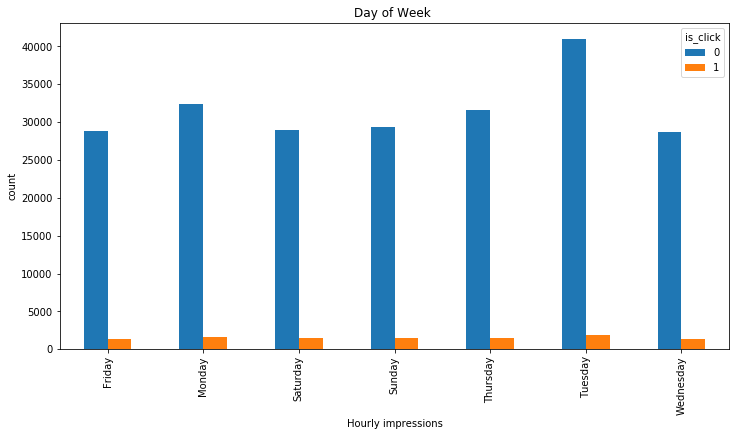

In [48]:
df_raw.groupby(['day_of_week','is_click']).size().unstack().plot(kind= 'bar',title="Day of Week ",figsize=(12,6))
plt.ylabel('count')
plt.xlabel('Hourly impressions')

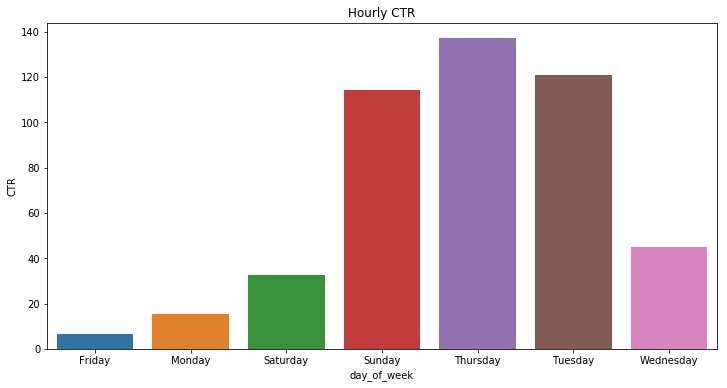

In [50]:
df_click = df_raw[df_raw['is_click'] == 1]
df_dayofweek = df_raw[['day_of_week','is_click']].groupby(['day_of_week']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'is_click': 'impressions'})
df_dayofweek['clicks'] = df_click[['day_of_week','is_click']].groupby(['day_of_week']).count().reset_index()['is_click']
df_dayofweek['CTR'] = df_dayofweek['clicks']/df_hour['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='day_of_week', data=df_dayofweek)
plt.title('Hourly CTR');

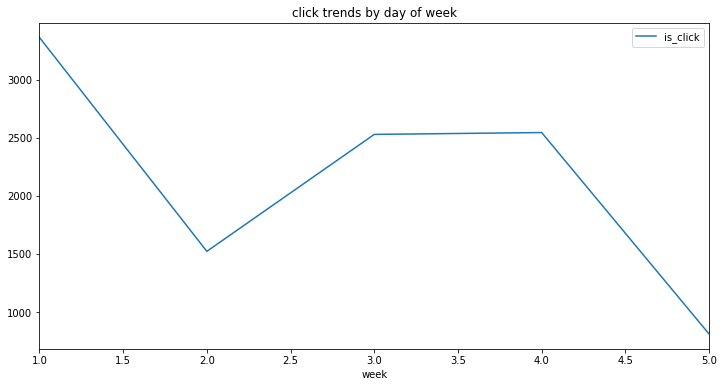

In [15]:
df_raw['week_of_month'] = df_raw['impression_time'].apply(lambda d: (d.day-1)//7+1)
# cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_raw.groupby('week_of_month').agg({'is_click':'sum'}).plot(figsize=(12,6))
# ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
# labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xlabel('week')
plt.title('click trends by day of week');

Text(0.5, 0, 'day')

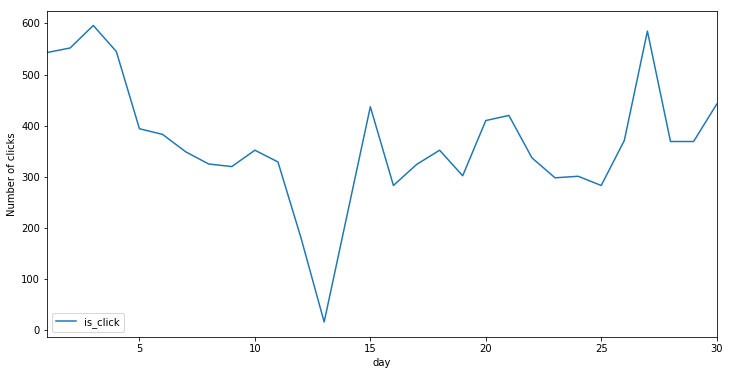

In [69]:
df_raw['day_of_month'] = df_raw.impression_time.apply(lambda x: x.day)
df_raw.groupby('day_of_month').agg({'is_click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.xlabel('day')

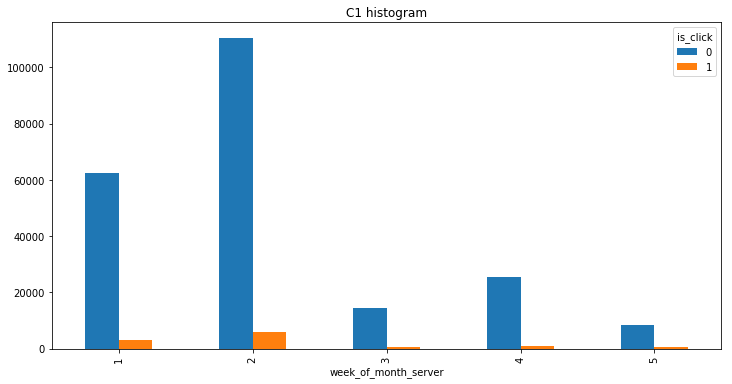

In [82]:
df_raw.groupby(['week_of_month_server', 'is_click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C1 histogram')

Text(0.5, 0, 'hour')

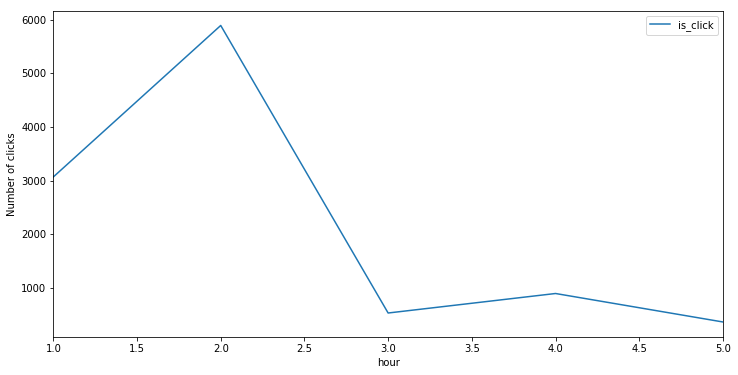

In [81]:
df_raw['week_of_month_server'] = df_raw.server_accessed_last.apply(lambda x: (x.day-1)//7+1)
df_raw.groupby('week_of_month_server').agg({'is_click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.xlabel('hour')

In [37]:
df_raw['server_accessed_short']= df_raw['server_accessed'].map(lambda a: 1 if a<9 else 0)
df_raw['server_accessed_med'] = df_raw['server_accessed'].map(lambda a: 1 if a>9 and a<25 else 0)
df_raw['server_accessed_high'] = df_raw['server_accessed'].map(lambda a: 1 if a>25 and a<59 else 0)
df_raw['server_accessed_vhigh'] = df_raw['server_accessed'].map(lambda a: 1 if a>59 else 0)

In [58]:
df_raw['Avg_item_price_short']= df_raw['Avg_item_price'].map(lambda a: 1 if a<5486 else 0)
df_raw['Avg_item_price_med'] = df_raw['Avg_item_price'].map(lambda a: 1 if a>5486 and a<8689 else 0)
df_raw['Avg_item_price_high'] = df_raw['Avg_item_price'].map(lambda a: 1 if a>8689 and a<12732 else 0)
df_raw['Avg_item_price_vhigh'] = df_raw['Avg_item_price'].map(lambda a: 1 if a>12732 else 0)

In [57]:
df_raw.Most_Product_type_checked.describe()

count    231810.000000
mean      10791.426509
std       10570.606747
min          23.000000
25%        5486.000000
50%        8689.000000
75%       12732.000000
max      250921.000000
Name: Avg_item_price, dtype: float64

In [44]:
df_raw['unique_items_checked_short']= df_raw['unique_items_checked'].map(lambda a: 1 if a<6 else 0)
df_raw['unique_items_checked_med'] = df_raw['unique_items_checked'].map(lambda a: 1 if a>6 and a<16 else 0)
df_raw['unique_items_checked_high'] = df_raw['unique_items_checked'].map(lambda a: 1 if a>16 and a<37else 0)
df_raw['unique_items_checked_vhigh'] = df_raw['unique_items_checked'].map(lambda a: 1 if a>59 else 0)

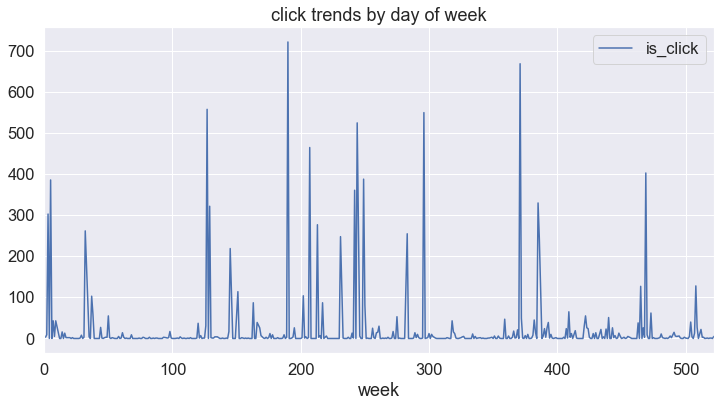

In [33]:
df_raw.groupby('app_code').agg({'is_click':'sum'}).plot(figsize=(12,6))
# ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
# labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xlabel('week')
plt.title('click trends by day of week');

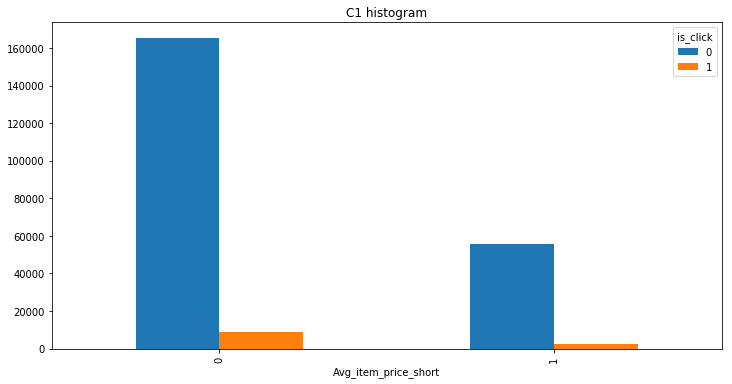

In [67]:
df_raw.groupby(['Avg_item_price_short', 'is_click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C1 histogram')

In [85]:
df_raw.to_feather("tmp/wns_final_f")

In [50]:
df_raw = feather.read_dataframe('tmp/wns_final_f')

In [5]:
df_raw.head().T

,0,1,2,3,4
impression_id,c4ca4238a0b923820dcc509a6f75849b,621bf66ddb7c962aa0d22ac97d69b793,ab394288aed46588bdc90bf4b541ec0d,45c48cce2e2d7fbdea1afc51c7c6ad26,6b18886bc278247582704943f5c66eb9
impression_time,2018-11-15 00:00:00,2018-11-15 00:19:00,2018-11-16 17:29:00,2018-11-15 00:01:00,2018-11-16 16:31:00
user_id,87862,87862,87862,63410,63410
app_code,422,422,422,467,467
os_version,2,2,2,0,0
is_4G,0,0,0,1,1
is_click,0,0,0,1,0
device_type,0,0,0,0,0
server_accessed,1,1,1,12,12
unique_items_checked,1,1,1,7,7


In [51]:
train_cats(df_raw)

In [52]:
df_raw.day_of_week.cat.set_categories(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],ordered=True,inplace=True)
df_raw.day_of_week_server.cat.set_categories(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],ordered=True,inplace=True)

In [53]:
df_raw.day_of_week = df_raw.day_of_week.cat.codes
df_raw.day_of_week_server = df_raw.day_of_week_server.cat.codes

In [54]:
df_raw.drop(["server_accessed_short","server_accessed_med","server_accessed_high","server_accessed_vhigh",
             "unique_items_checked_short",'unique_items_checked_med','unique_items_checked_high',
             'unique_items_checked_vhigh','Avg_item_price_short','Avg_item_price_med','Avg_item_price_high',
             'Avg_item_price_vhigh'],axis=1,inplace=True)

In [57]:
df_raw.drop(['hour_of_day_server','day_of_month_server',"month_of_year_server",'week_of_month_server','day_of_week_server'],axis=1,inplace=True)

In [65]:
df_raw.to_feather('tmp/wns_final_f')

In [59]:
df_raw.drop(['Most_Product_type_checked','Sec_Most_Product_type_checked','Third_Most_Product_type_checked','unique_items_checked'],axis=1,inplace=True)

In [60]:
df_raw

,0,1,2,3,4
impression_id,c4ca4238a0b923820dcc509a6f75849b,621bf66ddb7c962aa0d22ac97d69b793,ab394288aed46588bdc90bf4b541ec0d,45c48cce2e2d7fbdea1afc51c7c6ad26,6b18886bc278247582704943f5c66eb9
impression_time,2018-11-15 00:00:00,2018-11-15 00:19:00,2018-11-16 17:29:00,2018-11-15 00:01:00,2018-11-16 16:31:00
user_id,87862,87862,87862,63410,63410
app_code,422,422,422,467,467
os_version,2,2,2,0,0
is_4G,0,0,0,1,1
is_click,0,0,0,1,0
device_type,0,0,0,0,0
server_accessed,1,1,1,12,12
server_accessed_last,2018-10-19 18:11:00,2018-10-19 18:11:00,2018-10-19 18:11:00,2018-12-10 20:03:00,2018-12-10 20:03:00


In [63]:
df_raw['days_since_visit']  = df_raw['impression_time'] - df_raw['server_accessed_last']
df_raw['days_since_visit'] = df_raw['days_since_visit']/np.timedelta64(1,'D')

In [64]:
df_raw.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,device_type,server_accessed,server_accessed_last,Avg_item_price,hour_of_day,day_of_week,week_of_month,day_of_month,days_since_visit
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,2,0,0,0,1,2018-10-19 18:11:00,2350,0,3,3,15,26.242361
1,621bf66ddb7c962aa0d22ac97d69b793,2018-11-15 00:19:00,87862,422,2,0,0,0,1,2018-10-19 18:11:00,2350,0,3,3,15,26.255556
2,ab394288aed46588bdc90bf4b541ec0d,2018-11-16 17:29:00,87862,422,2,0,0,0,1,2018-10-19 18:11:00,2350,17,4,3,16,27.970833
3,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,0,1,1,0,12,2018-12-10 20:03:00,4452,0,3,3,15,-25.834722
4,6b18886bc278247582704943f5c66eb9,2018-11-16 16:31:00,63410,467,0,1,0,0,12,2018-12-10 20:03:00,4452,16,4,3,16,-24.147222


In [15]:
df_raw.drop('server_accessed_last',axis=1,inplace=True)

In [49]:
df_raw.head()

,os_version,is_4G,is_click,device_type,unique_items_checked,Avg_item_price,hour_of_day,day_of_week,week_of_month,day_of_month,hour_of_day_server,day_of_month_server,month_of_year_server,week_of_month_server,day_of_week_server
0,2,0,0,0,1,2350,0,3,3,15,18,19,10,3,4
1,2,0,0,0,1,2350,0,3,3,15,18,19,10,3,4
2,2,0,0,0,1,2350,17,4,3,16,18,19,10,3,4
3,0,1,1,0,7,4452,0,3,3,15,20,10,12,2,0
4,0,1,0,0,7,4452,16,4,3,16,20,10,12,2,0


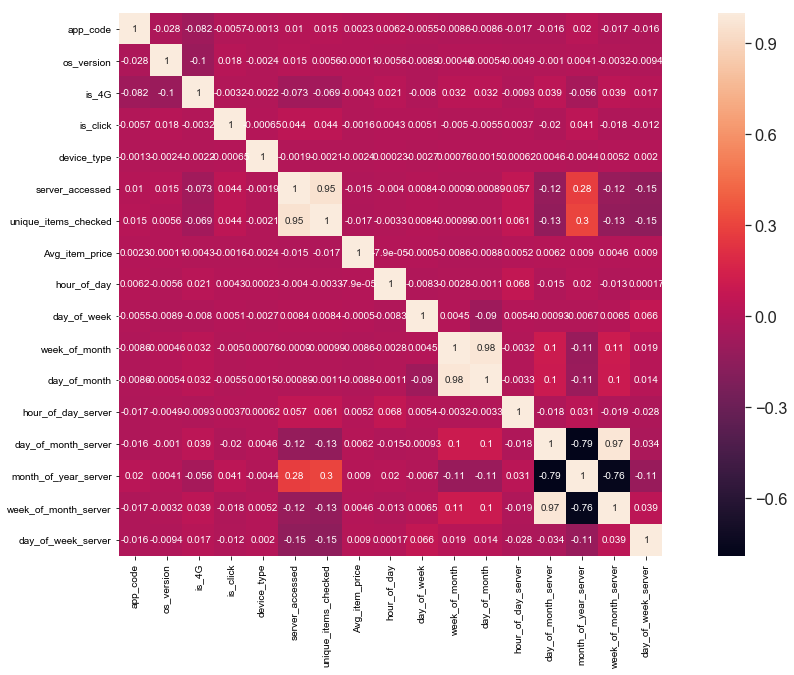

In [16]:
fig = plt.subplots(figsize= (20,10))
sns.set(font_scale=1.5)
sns.heatmap(df_raw.corr(),square=True,cbar=True,annot=True,annot_kws={'size':10})
plt.show()

In [105]:
df_raw.loc[df_raw.impression_time == "2018-12-01"]

,impression_time,app_code,os_version,is_4G,is_click,device_type,server_accessed_last,hour_of_day,day_of_week,week_of_month,...,Avg_item_price_short,Avg_item_price_med,Avg_item_price_high,Avg_item_price_vhigh,day_of_month,hour_of_day_server,day_of_month_server,month_of_year_server,week_of_month_server,day_of_week_server
10654,2018-12-01,250,0,0,0,0,2018-12-11 16:28:00,0,Saturday,1,...,1,0,0,0,1,16,11,12,2,Tuesday
44591,2018-12-01,283,1,1,0,0,2018-12-11 20:23:00,0,Saturday,1,...,0,0,0,1,1,20,11,12,2,Tuesday
51358,2018-12-01,283,0,0,0,0,2018-12-05 22:39:00,0,Saturday,1,...,0,0,1,0,1,22,5,12,1,Wednesday
54498,2018-12-01,190,0,0,0,0,2018-11-30 03:20:00,0,Saturday,1,...,1,0,0,0,1,3,30,11,5,Friday
64477,2018-12-01,469,0,0,1,0,2018-12-08 10:17:00,0,Saturday,1,...,1,0,0,0,1,10,8,12,2,Saturday
95884,2018-12-01,463,0,0,0,0,2018-12-10 17:09:00,0,Saturday,1,...,0,0,0,1,1,17,10,12,2,Monday
102031,2018-12-01,242,2,0,0,0,2018-12-06 21:11:00,0,Saturday,1,...,0,0,0,1,1,21,6,12,1,Thursday
106160,2018-12-01,463,2,0,1,0,2018-12-11 10:18:00,0,Saturday,1,...,0,0,0,1,1,10,11,12,2,Tuesday
121033,2018-12-01,409,0,1,0,0,2018-12-02 10:43:00,0,Saturday,1,...,1,0,0,0,1,10,2,12,1,Sunday
161072,2018-12-01,190,2,0,0,0,2018-11-30 23:22:00,0,Saturday,1,...,1,0,0,0,1,23,30,11,5,Friday


In [17]:
df_valid = df_raw.loc[df_raw.impression_time > '2018-12-11 23:59:59'] 

In [18]:
df_raw = df_raw.loc[df_raw.impression_time < '2018-12-11 23:59:59']

In [19]:
df_raw = pd.DataFrame(df_raw).reset_index()
df_valid = pd.DataFrame(df_valid).reset_index()

In [20]:
df_raw.drop(['impression_time','index'],inplace=True,axis=1)
df_valid.drop(['impression_time','index'],inplace=True,axis=1)

In [21]:
df_raw.to_feather('tmp\wns_train')
df_valid.to_feather('tmp\wns_valid')

In [22]:
df_raw = feather.read_dataframe('tmp/wns_train')
df_valid = feather.read_dataframe('tmp/wns_valid')

In [116]:
train_cats(df_raw)
train_cats(df_valid)

In [119]:
df_valid.day_of_week.cat.categories

Index(['Thursday', 'Wednesday'], dtype='object')

In [23]:
df_raw.isnull().sum().sort_index()/len(df_raw)

Avg_item_price          0.0
app_code                0.0
day_of_month            0.0
day_of_month_server     0.0
day_of_week             0.0
day_of_week_server      0.0
device_type             0.0
hour_of_day             0.0
hour_of_day_server      0.0
is_4G                   0.0
is_click                0.0
month_of_year_server    0.0
os_version              0.0
server_accessed         0.0
unique_items_checked    0.0
week_of_month           0.0
week_of_month_server    0.0
dtype: float64

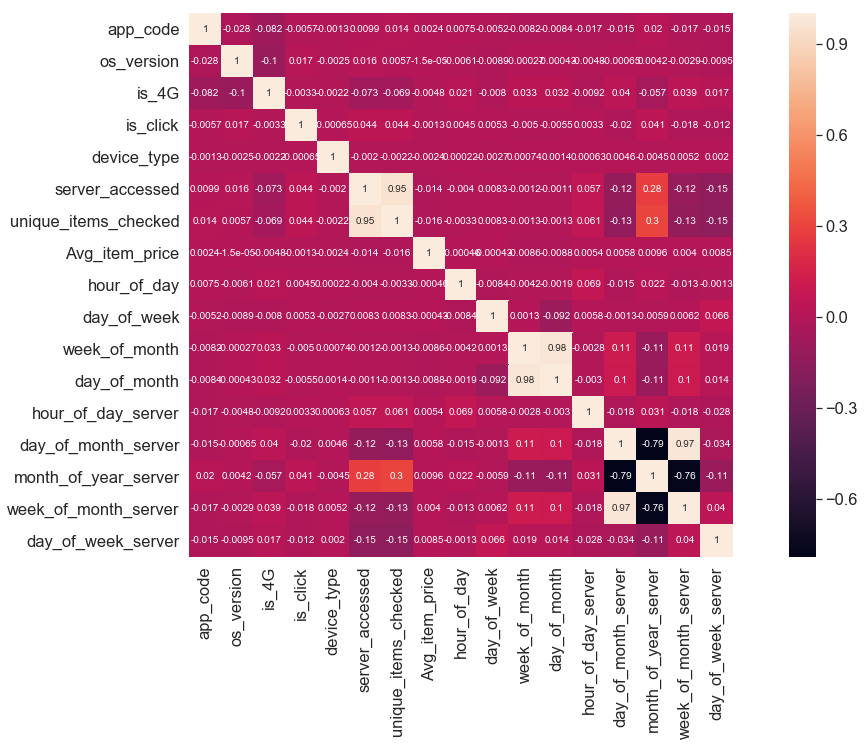

In [24]:
fig = plt.subplots(figsize= (20,10))
sns.set(font_scale=1.5)
sns.heatmap(df_raw.corr(),square=True,cbar=True,annot=True,annot_kws={'size':10})
plt.show()

In [45]:
df_raw.drop('server_accessed',axis=1,inplace=True)
df_valid.drop('server_accessed',axis=1,inplace=True)

In [34]:
df_raw.drop('app_code',axis=1,inplace=True)
df_valid.drop('app_code',axis=1,inplace=True)

In [ ]:
df_raw.drop(['server_accessed',],axis=1,inplace=True)

In [185]:
df_raw.drop(["Avg_item_price_short","Avg_item_price_med","Avg_item_price_high",'Avg_item_price_vhigh'],axis=1,inplace=True)

In [ ]:
df_raw.drop(["server_accessed_short","server_accessed_med","server_accessed_high",'server_accessed__vhigh',],axis=1,inplace=True)

In [192]:
df_valid.drop(["Avg_item_price_short","Avg_item_price_med","Avg_item_price_high",'Avg_item_price_vhigh'],axis=1,inplace=True)

In [48]:
df_raw.head()

,os_version,is_4G,is_click,device_type,unique_items_checked,Avg_item_price,hour_of_day,day_of_week,week_of_month,day_of_month,hour_of_day_server,day_of_month_server,month_of_year_server,week_of_month_server,day_of_week_server
0,2,0,0,0,1,2350,0,3,3,15,18,19,10,3,4
1,2,0,0,0,1,2350,0,3,3,15,18,19,10,3,4
2,2,0,0,0,1,2350,17,4,3,16,18,19,10,3,4
3,0,1,1,0,7,4452,0,3,3,15,20,10,12,2,0
4,0,1,0,0,7,4452,16,4,3,16,20,10,12,2,0


In [35]:
X_train,y_train,nas = proc_df(df_raw,'is_click')
X_valid,y_valid,nas = proc_df(df_valid,'is_click')

In [36]:
X_train.shape,X_valid.shape

((227814, 15), (3996, 15))

In [27]:
X_valid.isnull().sum().sort_index()/len(X_train)

Avg_item_price          0.0
app_code                0.0
day_of_month            0.0
day_of_month_server     0.0
day_of_week             0.0
day_of_week_server      0.0
device_type             0.0
hour_of_day             0.0
hour_of_day_server      0.0
is_4G                   0.0
month_of_year_server    0.0
os_version              0.0
server_accessed         0.0
unique_items_checked    0.0
week_of_month           0.0
week_of_month_server    0.0
dtype: float64

In [224]:
X_valid.drop('user_id',axis=1,inplace=True)
X_train.drop('user_id',axis=1,inplace=True)

KeyError: "['user_id'] not found in axis"

In [ ]:
X_valid.drop(['Sec_Most_Product_type_checked','Third_Most_Product_type_checked'],axis=1,inplace=True)
X_train.drop(['Sec_Most_Product_type_checked','Third_Most_Product_type_checked'],axis=1,inplace=True)

In [ ]:
X_valid.drop('Most_Product_type_checked',axis=1,inplace=True)
X_train.drop('Most_Product_type_checked',axis=1,inplace=True)

In [ ]:
# X_train = X_train.values
# X_valid = X_valid.values

In [227]:
Counter(y_valid)

Counter({0: 3800, 1: 196})

In [39]:
set_rf_samples(50000)

In [38]:
reset_rf_samples()

In [40]:
smote = SMOTE(random_state=42)

In [41]:
X_train_resampled,y_train_resampled = smote.fit_resample(X_train,y_train)

In [204]:
from imblearn.under_sampling import RandomUnderSampler

In [206]:
Rmote = RandomUnderSampler(random_state=42)

In [208]:
X_train_under,y_train_under = Rmote.fit_resample(X_train_resampled,y_train_resampled)

In [209]:
X_train_under.shape

(434486, 20)

In [42]:
Counter(y_train_resampled)

Counter({0: 217243, 1: 217243})

In [46]:
params = [2,3,4,5,6,7,8,9,10]
# for x in params:
m = RandomForestClassifier(n_estimators=100,max_features='sqrt',class_weight='balanced',random_state=42,n_jobs=-1)
m.fit(X_train_resampled,y_train_resampled)
print(classification_report(y_valid,m.predict(X_valid)))
print(roc_auc_score(y_valid,m.predict(X_valid)))
# print(m.oob_score_)

              precision    recall  f1-score   support

           0       0.95      0.34      0.50      3800
           1       0.05      0.68      0.09       196

    accuracy                           0.36      3996
   macro avg       0.50      0.51      0.30      3996
weighted avg       0.91      0.36      0.48      3996

0.5108646616541354


In [47]:
fi =rf_feat_importance(m,X_train);fi[:10]

,cols,imp
9,day_of_month,0.122564
5,Avg_item_price,0.108369
6,hour_of_day,0.096377
3,server_accessed,0.096284
7,day_of_week,0.089491
4,unique_items_checked,0.086506
10,hour_of_day_server,0.081201
11,day_of_month_server,0.075073
14,day_of_week_server,0.064295
8,week_of_month,0.052272


Here We do all the EDA AND Extract features that vary and help us to Predict Better